# Floristic Image Classification

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
import numpy as np
import seaborn as sns

2025-02-24 16:12:30.587336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740413550.603337   54226 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740413550.607574   54226 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 16:12:30.625124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Augmentation and Preprocessing

In [3]:
dataset_dir = 'FloristicSampleV1'  # Replace with the path to your dataset
img_size = (150, 150)  # Resize images to 150x150
batch_size = 32
num_classes = 3  # Arbustos, Gramíneas, Leguminosas

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Randomly zoom in/out
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=0.2  # Use 20% of data for validation
)

# Load Training Data
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    subset='training'
)

# Load Validation Data
val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Print class indices for training data
print("Class indices for training data:", train_generator.class_indices)

# Print class indices for validation data
print("Class indices for validation data:", val_generator.class_indices)

# Get class distribution
class_counts = np.sum(train_generator.classes[:, None] == np.arange(num_classes), axis=0)
print("Training class distribution after augmentation:", class_counts)
class_counts = np.sum(val_generator.classes[:, None] == np.arange(num_classes), axis=0)
print("Validation class distribution after augmentation:", class_counts)

# Get a batch of images and labels to check the output
images, labels = next(train_generator)
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

Found 161 images belonging to 3 classes.
Found 39 images belonging to 3 classes.
Class indices for training data: {'Arbustos': 0, 'Gramíneas': 1, 'Leguminosas': 2}
Class indices for validation data: {'Arbustos': 0, 'Gramíneas': 1, 'Leguminosas': 2}
Training class distribution after augmentation: [ 28  14 119]
Validation class distribution after augmentation: [ 7  3 29]
Images shape: (32, 150, 150, 3), Labels shape: (32, 3)


### Build the CNN model

In [4]:
model = models.Sequential([
    # First Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),

    # Flatten the output
    layers.Flatten(),
    
    # Output Layer (3 classes)
    layers.Dense(num_classes, activation='softmax')
])

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print Model Summary
model.summary()

/home/rafael/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-24 16:12:42.595840: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-02-24 16:12:42.595860: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: rafael-VivoBook-ASUSLaptop-X571LI-F571LI
2025-02-24 16:12:42.595864: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: rafael-VivoBook-ASUSLaptop-X571LI-F571LI
2025-02-24 16:12:42.596014: I external/local_xla/xla/stream_executor/cuda/cuda_diagno

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1401856)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │     4,205,571 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,207,363 (16.05 MB)

 Trainable params: 4,207,363 (16.05 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [5]:
epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
    # class_weight=class_weights  # Apply class weighting
)

/home/rafael/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step - accuracy: 0.4259 - loss: 25.4529 - val_accuracy: 0.8125 - val_loss: 9.5806
Epoch 2/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step - accuracy: 0.8750 - loss: 6.2232

2025-02-24 16:13:44.153865: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/rafael/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.8750 - loss: 6.2232 - val_accuracy: 0.7143 - val_loss: 2.6211
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.8137 - loss: 5.8991
Epoch 4/20


2025-02-24 16:14:15.080497: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.1562 - loss: 4.6303 - val_accuracy: 0.5312 - val_loss: 1.3832
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - accuracy: 0.6574 - loss: 3.4817 - val_accuracy: 0.7143 - val_loss: 8.4331
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7500 - loss: 11.7341
Epoch 7/20


2025-02-24 16:15:01.229778: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.8301 - loss: 5.6177 - val_accuracy: 0.9375 - val_loss: 2.7387
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.7812 - loss: 4.5665 - val_accuracy: 0.8571 - val_loss: 4.7509
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.8756 - loss: 2.5627
Epoch 10/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - accuracy: 0.8438 - loss: 1.9295

2025-02-24 16:16:05.844443: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8438 - loss: 1.9295 - val_accuracy: 0.9062 - val_loss: 1.0521
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - accuracy: 0.8691 - loss: 0.9214 - val_accuracy: 1.0000 - val_loss: 0.0357
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8750 - loss: 0.5434
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.7801 - loss: 0.5930 - val_accuracy: 0.9062 - val_loss: 0.4431
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - accuracy: 1.0000 - loss: 0.1985 - val_accuracy: 0.8571 - val_loss: 0.6364
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.6991 - loss: 1.1695
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6562 - loss: 1.0242 - val_accuracy: 0.9375 - val_loss: 0.3944
Epoch 17/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.8585 - loss: 0.6948 - val_accuracy: 0.7143 - val_loss: 1.7100
Epoch 18/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5312 - loss: 2.5362
Epoch 19/20

2025-02-24 16:19:11.959642: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - accuracy: 1.0000 - loss: 0.2323 - val_accuracy: 0.7143 - val_loss: 1.0145


### Evaluate the Model

In [6]:
# Evaluate on Validation Data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9450 - loss: 0.2052
Validation Loss: 0.19848842918872833
Validation Accuracy: 0.9487179517745972


### Visualize results

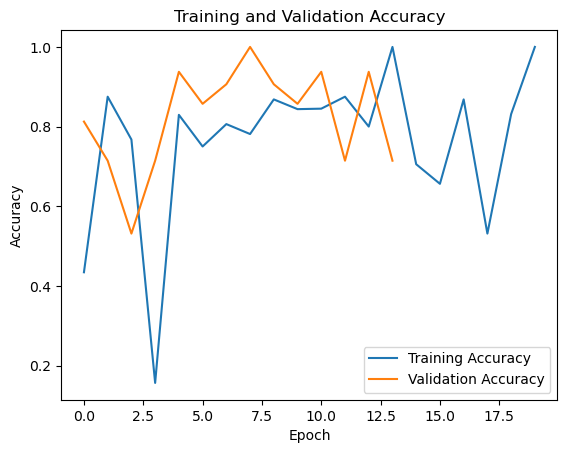

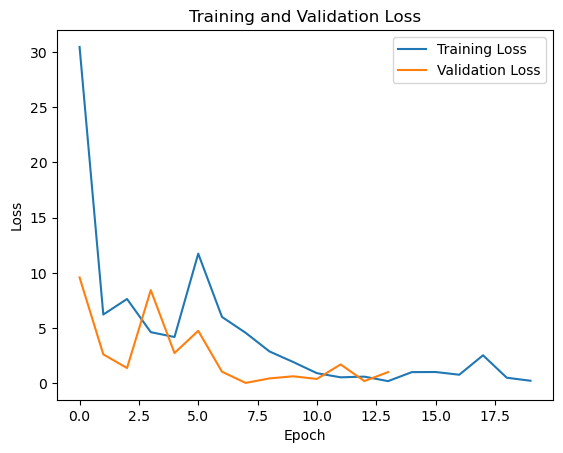

In [7]:
# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Confusion Matrix:
[[ 2  0  5]
 [ 1  0  2]
 [ 5  2 22]]
Matthews Correlation Coefficient (MCC): 0.0535


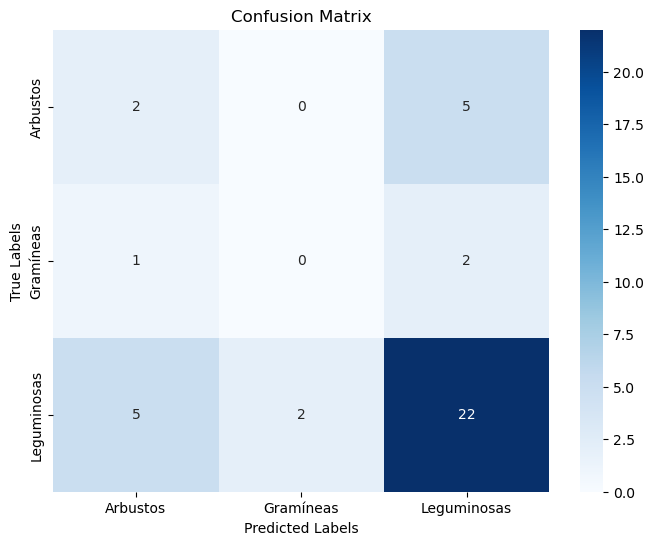

In [8]:
predictions = model.predict(val_generator, verbose=1)  
y_pred = np.argmax(predictions, axis=1)  
y_true = val_generator.classes  # True labels directly from generator  

cm = confusion_matrix(y_true, y_pred)
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Define class names (replace with your actual class names)
class_names = ['Arbustos', 'Gramíneas', 'Leguminosas']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Save the model

In [9]:
# model.save('basic_cnn_plant_classifier.h5')
print("Model saved as 'basic_cnn_plant_classifier.h5'")

Model saved as 'basic_cnn_plant_classifier.h5'
